In [1]:
import openai 
from langchain.text_splitter import CharacterTextSplitter


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

apipath = r'H:\\My Drive\\config\\hbqa.txt'
import configparser

config = configparser.ConfigParser()
config.read(apipath)

secret_key = config['global']['OPENAI_KEY']
datapath = config['global']['DATA_FOLDER']
corpuspath = config['global']['CORPUS_FOLDER']
corpus_sectionpath = config['global']['CORPUS_FOLDER_SECTIONS']
PINECONE_API_KEY = config['global']['PINECONE_KEY']
PINECONE_ENV = config['global']['PINECONE_ENV']
CHATPDF_KEY = config['global']['CHATPDF_KEY']

 

In [5]:
import pandas as pd 
df = pd.read_csv(datapath+'01.1-Mahabharat_Metadata.csv')
df.head(3)

,Book_Id,Book_Name,Section_Id,File_Name,URL,Section_Roman,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
0,1,Book 1: Adi Parva,Book01_002,mahabharata_01002.txt,https://www.mahabharataonline.com/translation/...,Section I,7464,44206,45,5.92
1,2,Book 1: Adi Parva,Book01_003,mahabharata_01003.txt,https://www.mahabharataonline.com/translation/...,Section II,8608,52123,33,6.06
2,3,Book 1: Adi Parva,Book01_004,mahabharata_01004.txt,https://www.mahabharataonline.com/translation/...,Section III,6089,35041,48,5.75


In [63]:
df.describe([.25,.50,.75,.90,.95, .99])

,Book_Id,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,1052.930476,1138.362381,6665.994762,5.341429,5.871605
std,608.453845,924.710517,5342.183066,4.669557,0.198274
min,1.000000,90.000000,514.000000,2.000000,5.260000
25%,525.750000,629.750000,3675.750000,3.000000,5.740000
50%,1052.500000,901.000000,5254.000000,4.000000,5.870000
75%,1580.250000,1343.000000,7919.000000,6.000000,5.990000
90%,1895.100000,1976.200000,11565.100000,9.000000,6.100000
95%,2001.050000,2574.400000,15047.200000,12.000000,6.170000
99%,2085.010000,4320.170000,25093.710000,21.010000,6.390100


# Create Chunk for Prompt Creation
- If we do not split and create chunk then ChatGPT cannot handle it. Secondly it will be more costly.
- These chunk should be used to to creating ChatGPT QA prompt.

In [144]:
def Create_Chunks(df1, df_chunks, idx_of_files, chunk_id, verbose):
    # split into chunks
    text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=8000,
        chunk_overlap=300,
        length_function=len
    )
    
    for i in idx_of_files:
        section_file_name = df1.loc[i,"File_Name"]
        section_id = df1.loc[i, "Section_Id"]
        Section_Word_Count = df1.loc[i, "Section_Word_Count"] 
        Section_Letter_Count = df1.loc[i,"Section_Letter_Count"]
        #question_to_generate = df1.loc[i,"Questions"]

        if verbose:
            print ("File:",section_file_name,
                    '| Sectionid:', section_id,
                    "| Section Words Count:", Section_Word_Count, 
                    "| Section Letter Count:",Section_Letter_Count,
                    #'| Questions:',question_to_generate
                    )
                 
        section_file_path = corpus_sectionpath+ section_file_name
        with open(section_file_path, "r") as file_section:
            text = file_section.readlines()
            text = "\n".join(text)
            # text = text.replace('\n\n \n\n', '\n')

        #print(section_file_name)  
        chunks = text_splitter.split_text(text)
        
        for chunk in chunks: 
            new_row = section_id, chunk_id, chunk 
            df_chunks.loc[chunk_id] = new_row
            chunk_id = chunk_id +1

    return chunk_id, df_chunks


In [150]:
# Initialize dataset for prompt 
df_chunks = pd.DataFrame(columns=['Section_Id','Chunk_Id','Chunk'])
# Initialize context_id
chunk_id = 1 

# Generate Questions & Answers for Sections.
idx_of_files = df.index
chunk_id, df_chunks = Create_Chunks(df, df_chunks, idx_of_files, chunk_id, verbose=False)
#print(f"{chunk_id} Chunks Generated")


Created a chunk of size 10832, which is longer than the specified 8000


Created a chunk of size 10810, which is longer than the specified 8000
Created a chunk of size 16668, which is longer than the specified 8000
Created a chunk of size 9381, which is longer than the specified 8000
Created a chunk of size 9897, which is longer than the specified 8000
Created a chunk of size 10162, which is longer than the specified 8000
Created a chunk of size 8639, which is longer than the specified 8000
Created a chunk of size 18774, which is longer than the specified 8000
Created a chunk of size 11551, which is longer than the specified 8000
Created a chunk of size 10646, which is longer than the specified 8000
Created a chunk of size 8495, which is longer than the specified 8000
Created a chunk of size 8097, which is longer than the specified 8000
Created a chunk of size 8213, which is longer than the specified 8000
Created a chunk of size 8013, which is longer than the specified 8000
Created a chunk of size 11989, which is longer than the specified 8000
Created a chu

In [151]:
df_chunks['Chunk_Letters'] = df_chunks['Chunk'].str.len()
df_chunks['Chunk_Words'] = df_chunks['Chunk'].str.split(' ').apply(len)
df_chunks.loc[:,'Chunk_Approx_Tokens'] = (df_chunks['Chunk_Words']*1.33).round()

In [152]:
df_chunks.shape

(2832, 6)

In [153]:
df_chunks[:3]

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
1,Book01_002,1,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7511,1214,1615.0
2,Book01_002,2,The Rishi Vyasa published this mass of knowled...,7552,1261,1677.0
3,Book01_002,3,"Vyasa executed the compilation of the Bharata,...",6986,1162,1545.0


In [154]:
df_chunks.describe([.25,.5,.8,.9,.95,.99])

,Chunk_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
count,2832.000000,2832.000000,2832.000000,2832.000000
mean,1416.500000,4943.800141,845.020127,1123.883475
std,817.672306,2485.739706,425.385475,565.752150
min,1.000000,1.000000,1.000000,1.000000
25%,708.750000,3238.750000,551.750000,733.750000
50%,1416.500000,4907.000000,834.000000,1109.000000
80%,2265.800000,6985.800000,1192.800000,1586.600000
90%,2548.900000,7663.000000,1311.000000,1744.000000
95%,2690.450000,7979.600000,1387.450000,1845.450000
99%,2803.690000,11932.440000,2045.140000,2720.520000


In [155]:
df_chunks.loc[df_chunks['Chunk_Words']<=50]

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
100,Book01_075,100,Section LXXIV\n(Sambhava Parva continued),40,4,5.0
143,Book01_106,143,"""Satyavati having succeeded with great difficu...",244,36,48.0
302,Book02_011,302,Section XI,10,2,3.0
307,Book02_014,307,Section XIV\n(Rajasuyarambha Parva),34,3,4.0
320,Book02_024,320,Section XXIV,12,2,3.0
...,...,...,...,...,...,...
1774,Book09_048,1774,48,2,1,1.0
1787,Book09_057,1787,57,2,1,1.0
1790,Book09_058,1790,"58\n""Sanjaya said, 'Beholding that fight thus ...",244,39,52.0
1838,Book11_015,1838,16\n(Stri-vilapa-parva),22,1,1.0


In [156]:
# Remove those chunk which has chapter name or page number or junk information.
df_chunks = df_chunks.loc[df_chunks['Chunk_Words']>50]


In [157]:
df_chunks.shape

(2746, 6)

In [158]:
# Save those chunks which are not being used for this project
# which are lessor than 25 percentile (too short) and more than 99 percentile (too big)
df_chunks[ (df_chunks['Chunk_Words']<400) | (df_chunks['Chunk_Words']>1000)].\
    to_csv(datapath+'03-Chunked_Book-Excluded.csv',index=None)

In [159]:
import numpy as np
excluded_chunks = np.array(df_chunks[ (df_chunks['Chunk_Words']<400) | \
                                      (df_chunks['Chunk_Words']>1000)].Chunk_Id.to_list())
print(excluded_chunks.shape) 
print(excluded_chunks)

(1313,)
[   1    2    3 ... 2828 2830 2831]


In [160]:
#drop chunks which are lessor than 25 percentile (too short) and more than 99 percentile (too big)
# Filter only those chunks which has token>800 and less then 2750
df_chunks = df_chunks[ (df_chunks['Chunk_Words']>=400) & (df_chunks['Chunk_Words']<=1000)]

In [161]:
df_chunks.shape

(1433, 6)

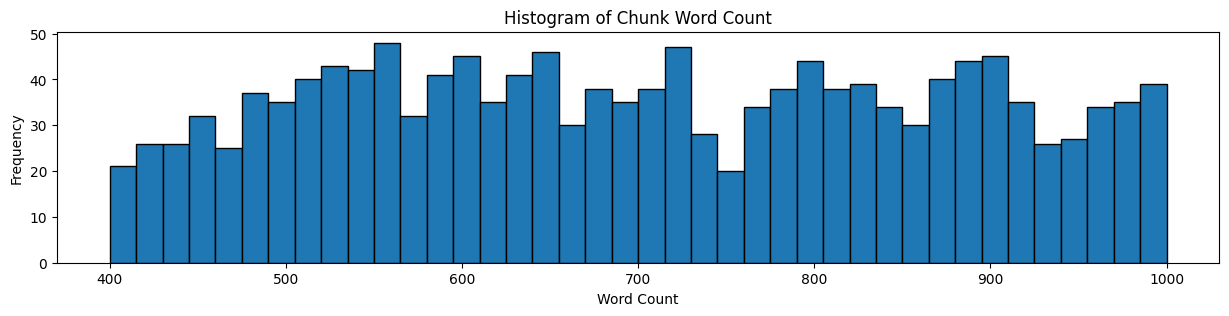

In [162]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.hist(df_chunks['Chunk_Words'], bins=40, edgecolor='k') 
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Chunk Word Count')
plt.show()

In [171]:
df_chunks['Approx_Ques'] = (df_chunks['Chunk_Words']/150).apply(round)

In [172]:
df_chunks.tail(33)

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
2783,Book15_014,2783,"Section XIV\n""Vaisampayana said,--'Thus addres...",3101,528,702.0,4
2784,Book15_015,2784,"Section XV\n""Vaisampayana said,--'The royal so...",2669,435,579.0,3
2785,Book15_016,2785,"Section XVI\n""Vaisampayana said, 'Great was th...",5134,871,1158.0,6
2786,Book15_017,2786,"Section XVII\n""Kunti said, 'It is even so, O m...",3609,654,870.0,4
2787,Book15_018,2787,"Section XVIII\n""Vaisampayana said, 'Hearing th...",3901,644,857.0,4
2788,Book15_019,2788,"Section XIX\n""Vaisampayana said. 'Following th...",2861,486,646.0,3
2791,Book15_022,2791,"Section XXII\n""Vaisampayana said, 'Those forem...",4114,715,951.0,5
2792,Book15_023,2792,"Section XXIII\n""Vaisampayana said. 'That forem...",2656,438,583.0,3
2793,Book15_024,2793,"Section XXIV\n""Vaisampayana said, 'The Pandava...",2896,477,634.0,3
2794,Book15_025,2794,"Section XXV\n""Vaisampayana said, 'The king, O ...",4433,784,1043.0,5


In [173]:
df_chunks.shape

(1433, 7)

In [174]:
df_chunks.describe()

,Chunk_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,1355.055129,4123.519191,703.622470,935.833217,4.691556
std,845.296182,987.518846,167.325004,222.528611,1.149346
min,4.000000,2197.000000,400.000000,532.000000,3.000000
25%,602.000000,3291.000000,559.000000,743.000000,4.000000
50%,1251.000000,4087.000000,698.000000,928.000000,5.000000
75%,2101.000000,4971.000000,849.000000,1129.000000,6.000000
max,2832.000000,6353.000000,1000.000000,1330.000000,7.000000


In [175]:
df_chunks.Approx_Ques.sum()

6723

In [176]:
df_chunks.to_csv(datapath+'03-Chunked_Book.csv',index=None)

In [179]:
df_chunks = pd.read_csv(datapath+'03-Chunked_Book.csv')
df_chunks.head(3)

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
0,Book01_002,4,"'Hear, O Sanjaya, all that happened thereupon ...",2742,505,672.0,3
1,Book01_003,8,"Section II\n""The Rishis said, 'O son of Suta, ...",5714,974,1295.0,6
2,Book01_003,9,"'Listen, O ye ascetics, to the outlines of the...",6353,974,1295.0,6


In [188]:
df_chunks['Book'] = df_chunks['Section_Id'].str.split("_").str[0]

In [189]:
df_chunks

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques,Book
0,Book01_002,4,"'Hear, O Sanjaya, all that happened thereupon ...",2742,505,672.0,3,Book01
1,Book01_003,8,"Section II\n""The Rishis said, 'O son of Suta, ...",5714,974,1295.0,6,Book01
2,Book01_003,9,"'Listen, O ye ascetics, to the outlines of the...",6353,974,1295.0,6,Book01
3,Book01_003,15,"""The above are the contents of the Eighteen Pa...",2997,517,688.0,3,Book01
4,Book01_004,16,"Section III\n(Paushya Parva)\nSauti said, ""Jan...",5149,879,1169.0,6,Book01
...,...,...,...,...,...,...,...,...
1428,Book17_002,2821,"2\nVaishampayana said: ""Those princes of restr...",3989,654,870.0,4,Book17
1429,Book18_001,2823,"1\nOm! Having bowed down into Narayana, and to...",3998,669,890.0,4,Book18
1430,Book18_004,2827,"4\nVaishampayana said, ""King Yudhishthira, thu...",3523,608,809.0,4,Book18
1431,Book18_005,2829,Narada recited the Mahabharata to the gods; As...,2425,411,547.0,3,Book18


In [194]:
df_chunks.groupby(['Book'])['Approx_Ques'].sum()

Book
Book01     771
Book02     253
Book03    1056
Book04     216
Book05     641
Book06     383
Book07     619
Book08     227
Book09     130
Book10      68
Book11      64
Book12    1191
Book13     595
Book14     330
Book15     131
Book16      29
Book17       4
Book18      15
Name: Approx_Ques, dtype: int64

In [196]:
df_chunks.groupby(['Section_Id'])['Approx_Ques'].sum()

Section_Id
Book01_002     3
Book01_003    15
Book01_004     6
Book01_006     6
Book01_007     3
              ..
Book17_002     4
Book18_001     4
Book18_004     4
Book18_005     3
Book18_006     4
Name: Approx_Ques, Length: 1342, dtype: int64

# Add Small Chunk Questions Towards the End of 03-Chunked_Book.csv

In [19]:
df_chunks = pd.read_csv(datapath + '03-Chunked_Book.csv')
df_chunks

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
0,Book01_002,4,"'Hear, O Sanjaya, all that happened thereupon ...",2742,505,672.0,3
1,Book01_003,8,"Section II\n""The Rishis said, 'O son of Suta, ...",5714,974,1295.0,6
2,Book01_003,9,"'Listen, O ye ascetics, to the outlines of the...",6353,974,1295.0,6
3,Book01_003,15,"""The above are the contents of the Eighteen Pa...",2997,517,688.0,3
4,Book01_004,16,"Section III\n(Paushya Parva)\nSauti said, ""Jan...",5149,879,1169.0,6
...,...,...,...,...,...,...,...
1428,Book17_002,2821,"2\nVaishampayana said: ""Those princes of restr...",3989,654,870.0,4
1429,Book18_001,2823,"1\nOm! Having bowed down into Narayana, and to...",3998,669,890.0,4
1430,Book18_004,2827,"4\nVaishampayana said, ""King Yudhishthira, thu...",3523,608,809.0,4
1431,Book18_005,2829,Narada recited the Mahabharata to the gods; As...,2425,411,547.0,3


In [26]:
df_chunks1 = pd.read_csv(datapath + '03-Chunked_Book-Excluded.csv')

In [27]:
df_chunks1= df_chunks1[(df_chunks1['Chunk_Words']<400) & (df_chunks1['Chunk_Words']>100)]

In [28]:
df_chunks1

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
5,Book01_002,7,"""In former days, having placed the four Vedas ...",779,133,177.0
15,Book01_005,21,"Section IV\n(Pauloma Parva)\n'UGRASRAVA SAUTI,...",1988,341,454.0
16,Book01_011,27,Section X\n(Pauloma Parva continued)\nSauti sa...,1358,242,322.0
17,Book01_013,29,"Section XII\n(Pauloma Parva continued)\n""Sauti...",858,145,193.0
18,Book01_015,31,"Section XIV\n(Astika Parva continued)\n""Sauti ...",1074,184,245.0
...,...,...,...,...,...,...
1273,Book14_052,2722,When king Yudhishthira the just of Kuru's race...,1666,271,360.0
1289,Book14_092,2767,would do when seeing some injury done to him. ...,1948,339,451.0
1295,Book15_012,2781,"Section XII\n""Arjuna said, 'O Bhima, thou art ...",2146,369,491.0
1297,Book15_021,2790,"Section XXI\n"" Vaisampayana said, 'Upon the re...",2319,388,516.0


In [29]:
df_chunks1.loc[:,'Approx_Ques']=1

In [30]:
df_chunks1

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
5,Book01_002,7,"""In former days, having placed the four Vedas ...",779,133,177.0,1
15,Book01_005,21,"Section IV\n(Pauloma Parva)\n'UGRASRAVA SAUTI,...",1988,341,454.0,1
16,Book01_011,27,Section X\n(Pauloma Parva continued)\nSauti sa...,1358,242,322.0,1
17,Book01_013,29,"Section XII\n(Pauloma Parva continued)\n""Sauti...",858,145,193.0,1
18,Book01_015,31,"Section XIV\n(Astika Parva continued)\n""Sauti ...",1074,184,245.0,1
...,...,...,...,...,...,...,...
1273,Book14_052,2722,When king Yudhishthira the just of Kuru's race...,1666,271,360.0,1
1289,Book14_092,2767,would do when seeing some injury done to him. ...,1948,339,451.0,1
1295,Book15_012,2781,"Section XII\n""Arjuna said, 'O Bhima, thou art ...",2146,369,491.0,1
1297,Book15_021,2790,"Section XXI\n"" Vaisampayana said, 'Upon the re...",2319,388,516.0,1


In [34]:
pd.concat([df_chunks,df_chunks1]).to_csv(datapath + '03-Chunked_Book_Incl_Small_Chunk.csv',index=None)